# **Projet 6 : Classifiez automatiquement des biens de consommation**

# Notebook 1 : Analyse des données textuelles (description)

# Sommaire:

**Objectif**

**<a href="#C1">I) Fonctions de l'analyse </a>**
- <a href="#C2"> 1) Fonctions de préparation du corpus</a>
- <a href="#C3"> 2) Fonctions de création de features</a>
- <a href="#C4"> 3) Fonctions de clustering et réduction de dimensions</a>

**<a href="#C5"> II) Analyse exploratoire et pre-processing du corpus</a>**
- <a href="#C6"> 1) Nettoyage des targets (catégories)</a>
- <a href="#C7"> 2) Liste des mots non informatifs</a>
- <a href="#C8"> 3) Pre-processing des descriptions</a>
    
**<a href="#C9"> III) Creation de features et Clustering</a>**
- <a href="#C10"> 1) Bag of Words</a>
  - a) Count vectorizer
  - b) TF-IDF
- <a href="#C11"> 2) Word embedding : Word2Vec</a>
  - a) CBOW
  - b) Skip-Gram
- <a href="#C12"> 3) Word embedding : FastText</a>
  - a) CBOW
  - b) Skip-Gram
- <a href="#C13"> 4) Word embedding : BERT</a>
  - a) BERT with HuggingFace
  - b) BERT with Tensorflow
- <a href="#C14"> 5) Sentence embedding : USE-Universal Sentence Encoder (DAN)</a>
- <a href="#C15"> 6) Sentence embedding : S-BERT</a>

**<a href="#C16">IV) Analyse du meilleur modèle</a>**

&nbsp;

***

# **Objectif**

**Contexte :**

L’ entreprise "Place de marché” souhaite lancer une marketplace e-commerce. Pour cela, les vendeurs doivent attribuer une catégorie manuellement à leurs produits à partir d’une description et d’une photo.  Afin de passer à une plus large échelle et faciliter le processus, il devient nécessaire d’automatiser cette tâche.
  
_


**Mission :** 

Réaliser une première étude de faisabilité d'un moteur de classification afin d'attribuer automatiquement la catégorie à un article :
- Analyse de données textuelles (description) + Clustering
- Analyse de données visuelles (image) + Clustering
&nbsp;

_


**Données :**

Export de la base de données contenant 1050 produits, leur description et leur image associées
&nbsp;

_


**Livrables :**

Afin de répondre à cette mission, trois notebook ont été réalisé : 
- Notebook 1 : Analyse des données textuelles (description) et clusterisation
- Notebook 2 : Analyse des données visuelles (images) et clusterisation
- Notebook 3 : Combinaison du meilleur modèle de texte et d'image et classification supervisée

***

In [1]:
# Import des librairies de base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import des données
df = pd.read_csv("data/Flipkart/flipkart_com-ecommerce_sample_1050.csv")

# <a name="C1"> I) Fonctions de l'analyse </a>

## <a name="C2"> 1) Fonctions de préparation du corpus</a>

In [3]:
# Affichage des tokens
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import nltk
from tqdm import tqdm

def display_tokens_info(tokens):
    """display token info"""
    print(f"nb tokens {len(tokens)}, nb tokens uniques {len(set(tokens))}")
    print(tokens[:20])


##########################################
##########################################
# Tokenizer


def tokenizer_fct(sentence):
    # print(sentence)
    tokenizer = RegexpTokenizer(r"[a-zA-Z]+")
    word_tokens = tokenizer.tokenize(sentence)
    return word_tokens


##########################################
##########################################

# Stop words
stop_w = list(set(stopwords.words('english')))


def stop_word_filter_fct(list_words):
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

##########################################
##########################################

# lower case et alpha


def lower_start_fct(list_words):
    lw = [w.lower() for w in list_words]
    return lw

##########################################
##########################################


# Lemmatizer (base d'un mot)


def lemma_fct(list_words):
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

# stemming


def stemma_fct(list_words):
    stemmer = PorterStemmer()
    stem_w = [stemmer.stem(w) for w in list_words]
    return stem_w

##########################################
##########################################


def lst_non_informative(corpus,
                        stem_or_lem='lem',
                        thres_com=10):
    """basic function of text processing"""
    corpus_raw = "".join(corpus.values)
    word_tokens = tokenizer_fct(corpus_raw)
    lw = lower_start_fct(word_tokens)
    sw = stop_word_filter_fct(lw)

    if stem_or_lem == 'lem':
        trans = lemma_fct(sw)
    else:
        trans = stemma_fct(sw)

    # unique word
    tmp = pd.Series(trans).value_counts()
    list_unique_words = tmp[tmp == 1].reset_index()
    # common words
    list_common_words = tmp.head(thres_com).reset_index()
    # non informative words
    non_informative_words = pd.concat(
        [list_common_words['index'], list_unique_words['index']], ignore_index=True).to_list()

    return non_informative_words


##########################################
##########################################

def no_info_word_filter_fct(list_words, non_info_word):
    filtered_w = [w for w in list_words if not w in non_info_word]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

##########################################
##########################################

# Fonction de préparation du texte pour le bag of words avec lemm or stemming


def transform_bow_fct(desc_text, non_info_word, stem_or_lem='lem', rejoin=True):
    word_tokens = tokenizer_fct(desc_text)
    lw = lower_start_fct(word_tokens)
    sw = stop_word_filter_fct(lw)

    if stem_or_lem == 'lem':
        st_lem_w = lemma_fct(sw)
    else:
        st_lem_w = stemma_fct(sw)

    filt = no_info_word_filter_fct(st_lem_w, non_info_word)

    if rejoin:
        return " ".join(filt)

    return filt

## <a name="C3"> 2) Fonctions de création de features</a>

In [4]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length):
    """ Cette fonction permet de préparer les phrases afin d'appliquer le modèle d'embedding BERT"""

    input_ids = []
    token_type_ids = []
    attention_mask = []
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens=True,
                                              max_length=max_length,
                                              padding='max_length',
                                              return_attention_mask=True,
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf",
                                              verbose=False)

        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0],
                             bert_inp['token_type_ids'][0],
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)

    return input_ids, token_type_ids, attention_mask, bert_inp_tot

##########################################
##########################################


# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF'):
    """ Cette fonction permet de préparer les phrases afin d'appliquer le modèle d'embedding BERT"""

    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in tqdm(range(len(sentences)//batch_size)):
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size],
                                                                               bert_tokenizer, max_length)

        if mode == 'HF':    # Bert HuggingFace
            outputs = model.predict(
                [input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred, verbose=False)
            last_hidden_states = outputs.last_hidden_state

        if mode == 'TFhub':  # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids": input_ids,
                                 "input_mask": attention_mask,
                                 "input_type_ids": token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']

        if step == 0:
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else:
            last_hidden_states_tot = np.concatenate(
                (last_hidden_states_tot, last_hidden_states))

    features_bert = np.array(last_hidden_states_tot).mean(axis=1)

    time2 = np.round(time.time() - time1, 0)
    print("temps traitement : ", time2)

    return features_bert, last_hidden_states_tot

##########################################
##########################################


def feature_USE_fct(sentences, b_size):
    """ Cette fonction permet d'appliquer le modèle de sentence embedding USE """

    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size):
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step == 0:
            features = feat
        else:
            features = np.concatenate((features, feat))

    time2 = np.round(time.time() - time1, 0)
    print("temps traitement : ", time2)

    return features

## <a name="C4"> 3) Fonctions de clustering et réduction de dimensions</a>

In [5]:
import time
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import TruncatedSVD
from umap import UMAP
from sklearn.preprocessing import LabelEncoder


def select_n_components(features, goal_var: float) -> int:
    """ 
    La méthode PCA de sklearn permet de selectionner un float en n_compoents afin de ne garder que 0.99 (par ex) de la variance totale mais cela n'est pas possible pour la méthode SVD.
    Cette function permet de récupérer le nombre de composantes expliquant X%  de la variance totale par la méthode de réduction SVD. 
    """

    # Création et fit du modèle
    tsvd = TruncatedSVD(n_components=features.shape[1]-1)
    tsvd.fit(features)
    tsvd_var_ratios = tsvd.explained_variance_ratio_

    # Initialisation
    total_variance = 0.0
    n_components = 0

    # boucle pour avoir le nombre de composante expliquant goal_var variance :
    for explained_variance in tsvd_var_ratios:

        # somme de la variance expliquée par itération
        total_variance += explained_variance

        # Nb composantes +1 par itération
        n_components += 1

        # Si la variance totale > objectifs
        if total_variance >= goal_var:
            # Arrêt de la boucle
            break

    # Return the number of components
    return n_components

##########################################
##########################################

# Calcul Reduction, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters


def reduction_fct(features, reduc='SVD'):
    """ Cette fonction permet de réduire et clusteriser des données 
    avec le choix de l'algorithme de réduction dans les arguments : SVD, UMAP ou TSNE
    """

    if reduc == 'SVD':
        n_comp = select_n_components(features, goal_var=0.99)
        print(f"Number of dimensions before TSVD: {features.shape[1]}")
        print(
            f"Number of dimensions after TSVD (99% var. explained): {n_comp}")
        modelSVD = TruncatedSVD(n_components=n_comp, random_state=42)
        reduc_X = modelSVD.fit_transform(features)
        return reduc_X

    elif reduc == 'TSNE':
        tsne = TSNE(n_components=2, perplexity=30, n_iter=2000,
                    init='random', learning_rate=200, random_state=42)
        reduc_X = tsne.fit_transform(features)
        return reduc_X

    elif reduc == 'UMAP':
        modelUMAP = UMAP(n_neighbors=200,
                         min_dist=1,
                         n_components=2,
                         random_state=42)
        reduc_X = modelUMAP.fit_transform(features)
        return reduc_X

    else:
        print("please select 'SVD' (PCA equivalent for sparse data),'TSNE' or 'UMAP'")

##########################################
##########################################


def kmeans_fct(features, y_categ):
    """ Fonction permettant de réaliser un kmeans et de calculer l'ARI entre les vrais labels et les labels prédits"""
    # Détermination des clusters à partir des données après Tsne
    num_labels = len(set(y_categ))
    cls = KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(features)
    ARI = np.round(adjusted_rand_score(y_categ, cls.labels_), 4)
    print("ARI : ", ARI)

    return ARI, cls.labels_


##########################################
##########################################

def reduc_visu_fct(reduc_X, target, labels):
    """visualisation des axes réduits (2 premiers) selon les vraies catégories et selon les clusters"""
    # Encodage des targets pour la couleur des clusters
    LE = LabelEncoder()
    y_categ = LE.fit_transform(target)
    categ = list(set(target))

    # représentation graphique
    fig = plt.figure(figsize=(20, 8))

    ax = fig.add_subplot(121)
    scatter = ax.scatter(reduc_X[:, 0], reduc_X[:, 1], c=y_categ, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[
              0], labels=categ, loc="best", title="Categorie")
    plt.title('Représentation des produits par catégories réelles')

    ax = fig.add_subplot(122)
    scatter = ax.scatter(reduc_X[:, 0], reduc_X[:, 1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(
        labels), loc="best", title="Clusters")
    plt.title('Représentation des produits par clusters')

    plt.show()

# <a name="C5"> II) Analyse exploratoire et pre-processing du corpus</a>

## <a name="C6"> 1) Nettoyage des targets (catégories)</a>

In [6]:
categ = df.product_category_tree

In [7]:
# retrait des crochets et guillements
categ = categ.apply(lambda x: x[2:-2])

# séparation en colonne par l'opérateur >>
categ = categ.str.split('>> ', 4, expand=True)

In [8]:
categ.head()

0                        1                  2  \
0  Home Furnishing   Curtains & Accessories           Curtains    
1        Baby Care         Baby Bath & Skin   Baby Bath Towels    
2        Baby Care         Baby Bath & Skin   Baby Bath Towels    
3  Home Furnishing                Bed Linen          Bedsheets    
4  Home Furnishing                Bed Linen          Bedsheets    

                                                   3  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Baby Bath Towels    
2                          Eurospa Baby Bath Towels    
3                   SANTOSH ROYAL FASHION Bedsheets    
4                            Jaipur Print Bedsheets    

                                                   4  
0                                               None  
1  Sathiyas Cotton Bath Towel (3 Bath Towel, Red,...  
2  Eurospa Cotton Terry Face Towel Set (20 PIECE ...  
3  SANTOSH ROYAL FASHION Cotton Printed King size...  
4  Jaipur Print Cotton Floral King sized Double B...

In [9]:
categ.describe().T

count unique               top freq
0  1050      7  Home Furnishing   150
1  1050     63    Wrist Watches   149
2  1047    246       Deodorants    65
3   679    350           Combos    64
4   405    348     Denver Combos    8

In [10]:
categ[0].value_counts()

Home Furnishing                150
Baby Care                      150
Watches                        150
Home Decor & Festive Needs     150
Kitchen & Dining               150
Beauty and Personal Care       150
Computers                      150
Name: 0, dtype: int64

In [11]:
df["Categ_A"] = categ[0]

## <a name="C7"> 2) Liste des mots non informatifs</a>

In [12]:
raw_corpus = "".join(df["description"].values)

In [13]:
# tokenize
corpus_processed = tokenizer_fct(raw_corpus)
# lower
corpus_processed = lower_start_fct(corpus_processed)
# stop word
corpus_processed = stop_word_filter_fct(corpus_processed)
# lemmatizer
corpus_processed = lemma_fct(corpus_processed)

# value counts of each word
tmp = pd.Series(corpus_processed).value_counts()
tmp.head(20).reset_index()

index    0
0       product  863
1          free  618
2      delivery  567
3          cash  564
4      shipping  564
5       genuine  564
6         price  561
7   replacement  559
8           day  553
9           buy  547
10     flipkart  476
11    guarantee  471
12          com  468
13          mug  448
14      feature  404
15       online  396
16        color  363
17        watch  354
18         type  325
19         baby  321

## <a name="C8"> 3) Pre-processing des descriptions</a>

In [14]:
lst_stop_word_manual_lem = ['r', 'key', 'product', 'feature', 'color', "type",
                            'specification', 'material', 'general',
                            'sale', 'number', 'warranty', 'detail',
                            'quality', 'inch', 'brand']

# Le value counts du corpus nettoyer indique que les 13 premeirs mots ne sont pas informatifs
# (de "product" à "com") -> thres_com = 13
non_informative_words_lem = lst_non_informative(
    df['description'], thres_com=13) + lst_stop_word_manual_lem

In [15]:
df['sentence_lem'] = df['description'].apply(
    lambda x: transform_bow_fct(x, non_informative_words_lem, stem_or_lem='lem'))

In [16]:
df.to_csv("data_cleaned.csv", index= False )

In [17]:
corpus_preprocessed = "".join(df['sentence_lem'].values)
word_tokens = tokenizer_fct(corpus_preprocessed)
display_tokens_info(word_tokens)

nb tokens 39567, nb tokens uniques 3910
['elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'height', 'pack', 'curtain', 'enhances']


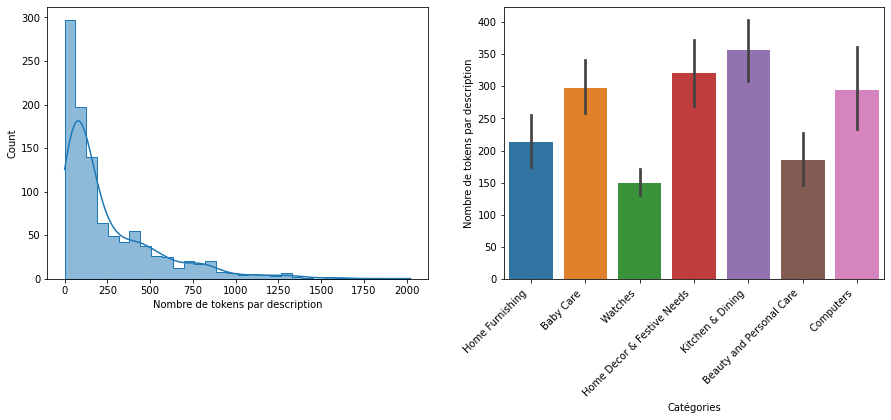

In [18]:
# Analyse du nombre de tokens par description de produit
tmp = df['sentence_lem'].str.len()
plt.figure(figsize=(15, 5))
plt.subplot(121)
sns.histplot(x=tmp, kde=True, element="step")
plt.xlabel("Nombre de tokens par description")
plt.subplot(122)
len_categ_plot = sns.barplot(
    data=df, x=df['Categ_A'], y=df['sentence_lem'].str.len())
plt.ylabel("Nombre de tokens par description")
plt.xlabel("Catégories")
len_categ_plot.set_xticklabels(len_categ_plot.get_xticklabels(),
                               rotation=45,
                               horizontalalignment='right')

plt.show()

In [19]:
df['sentence_lem'].str.len().groupby(df['Categ_A']).mean()

Categ_A
Baby Care                      298.073333
Beauty and Personal Care       185.033333
Computers                      294.026667
Home Decor & Festive Needs     320.340000
Home Furnishing                213.933333
Kitchen & Dining               356.940000
Watches                        149.526667
Name: sentence_lem, dtype: float64

# <a name="C9"> III) Creation de features et Clustering</a>

In [20]:
# Initialisation d'une liste vide pour les résultats du clustering (modèle, reduction, ARI) :

ARI_results = np.empty(shape=[0, 3])

## <a name="C10"> 1) Bag of Words</a>

### a) Count vectorizer

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

cvect = CountVectorizer(stop_words='english')

feat = 'sentence_lem'
cv_fit = cvect.fit(df[feat])

cv_transform = cvect.transform(df[feat])

In [22]:
# kmeans
ARI, labels = kmeans_fct(cv_transform, df['Categ_A'])

ARI_results = np.append(ARI_results, [["CV", "None", ARI]], axis=0)

ARI :  0.0358


Number of dimensions before TSVD: 3071
Number of dimensions after TSVD (99% var. explained): 538
ARI :  0.003


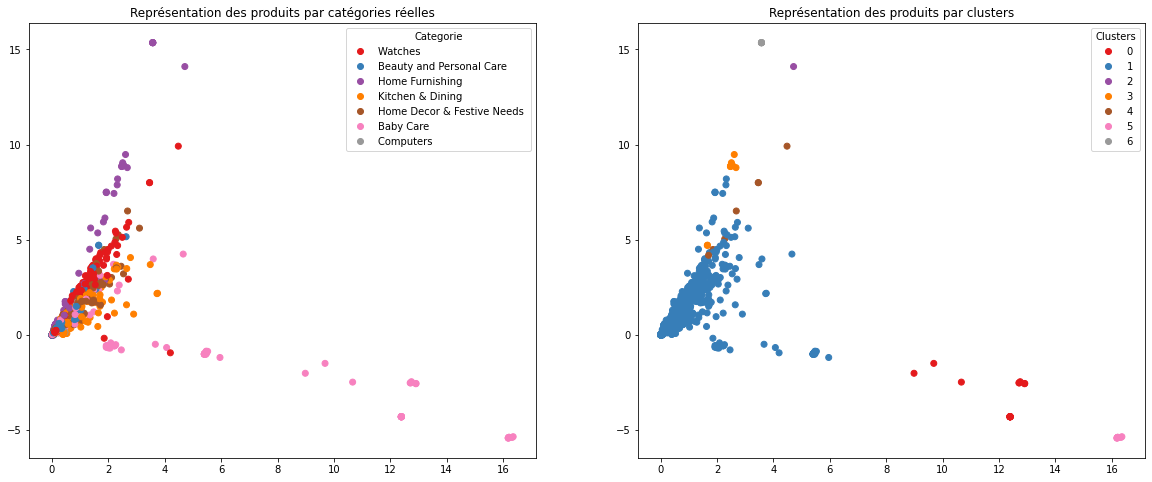

In [23]:
# SVD + kmeans
X_reduc = reduction_fct(cv_transform, reduc='SVD')
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])
reduc_visu_fct(X_reduc, df['Categ_A'], labels)

ARI_results = np.append(ARI_results, [["CV", "SVD", ARI]], axis=0)

ARI :  0.2671


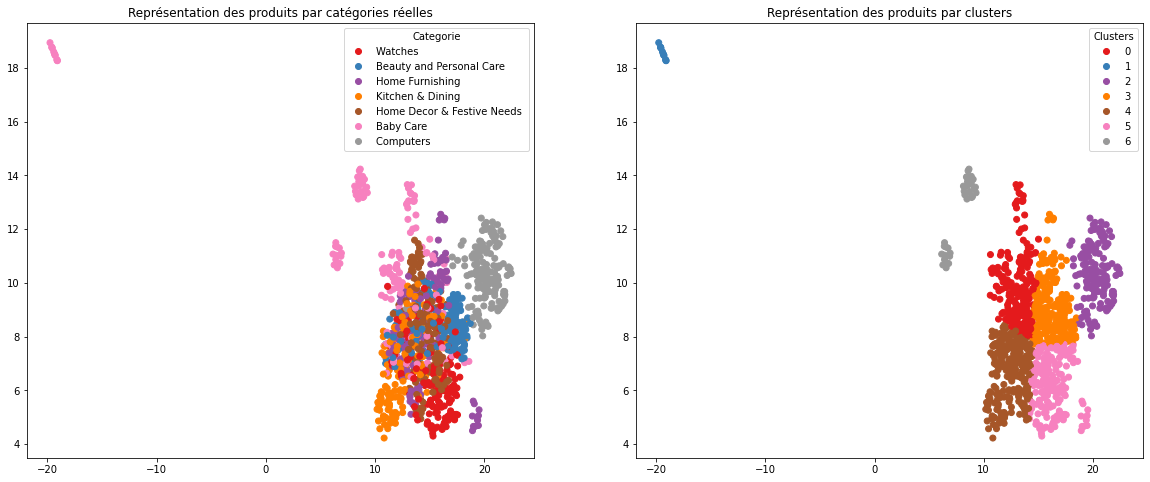

In [24]:
# UMAP + kmeans

X_reduc = reduction_fct(cv_transform, reduc='UMAP')
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])
reduc_visu_fct(X_reduc, df['Categ_A'], labels)

ARI_results = np.append(ARI_results, [["CV", "UMAP", ARI]], axis=0)

ARI :  0.4073


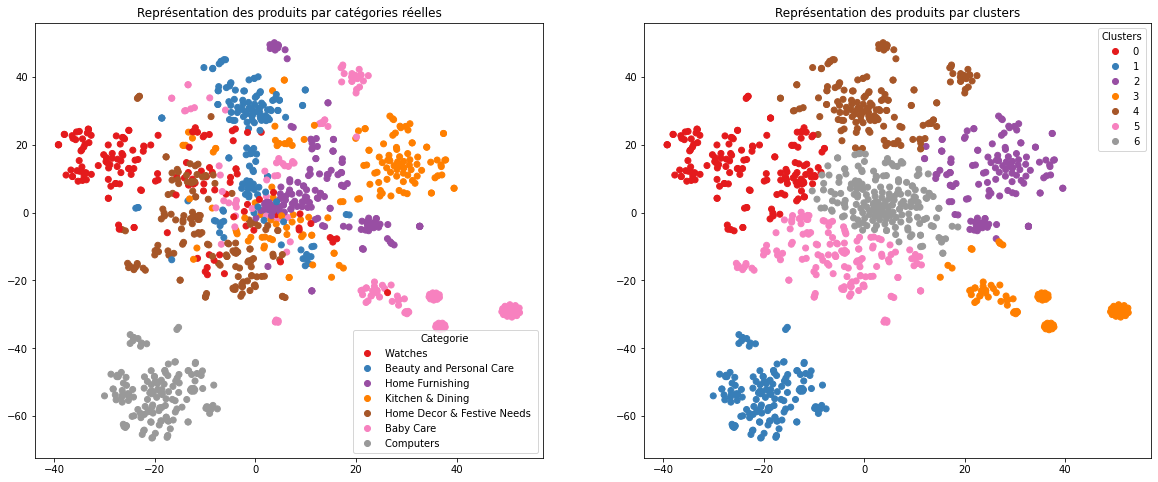

In [25]:
# TSNE + kmeans

X_reduc = reduction_fct(cv_transform, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])
reduc_visu_fct(X_reduc, df['Categ_A'], labels)


ARI_results = np.append(ARI_results, [["CV", "TSNE", ARI]], axis=0)

### b) TF-IDF

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

ctf = TfidfVectorizer(stop_words='english')

feat = 'sentence_lem'
ctf_fit = ctf.fit(df[feat])

ctf_transform = ctf.transform(df[feat])

In [27]:
# kmeans

ARI, labels = kmeans_fct(ctf_transform, df['Categ_A'])

ARI_results = np.append(ARI_results, [["TF-IDF", "None", ARI]], axis=0)

ARI :  0.2266


Number of dimensions before TSVD: 3071
Number of dimensions after TSVD (99% var. explained): 745
ARI :  0.2167


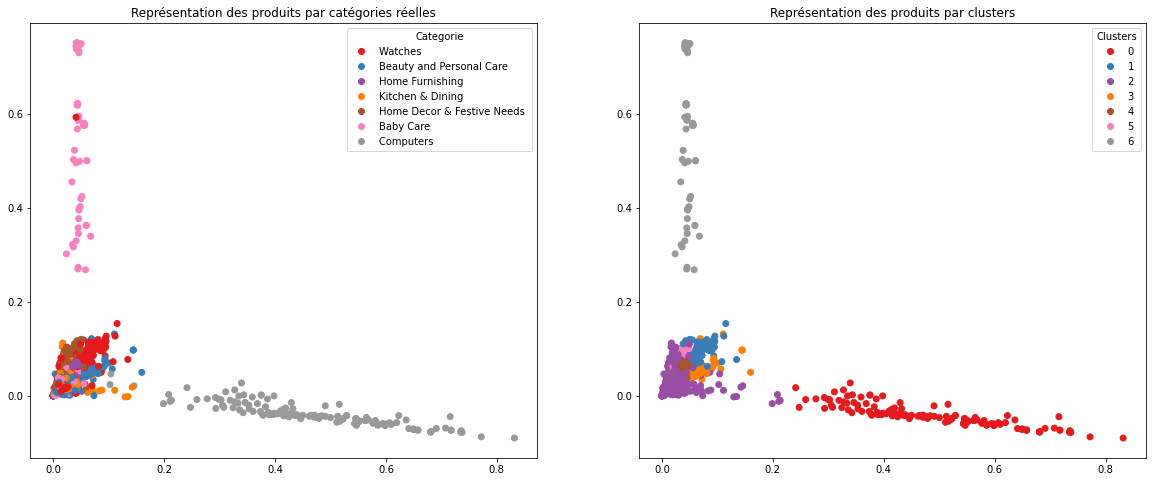

In [28]:
# SVD + kmeans

X_reduc = reduction_fct(ctf_transform, reduc='SVD')
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])
reduc_visu_fct(X_reduc, df['Categ_A'], labels)

ARI_results = np.append(ARI_results, [["TF-IDF", "SVD", ARI]], axis=0)

ARI :  0.4122


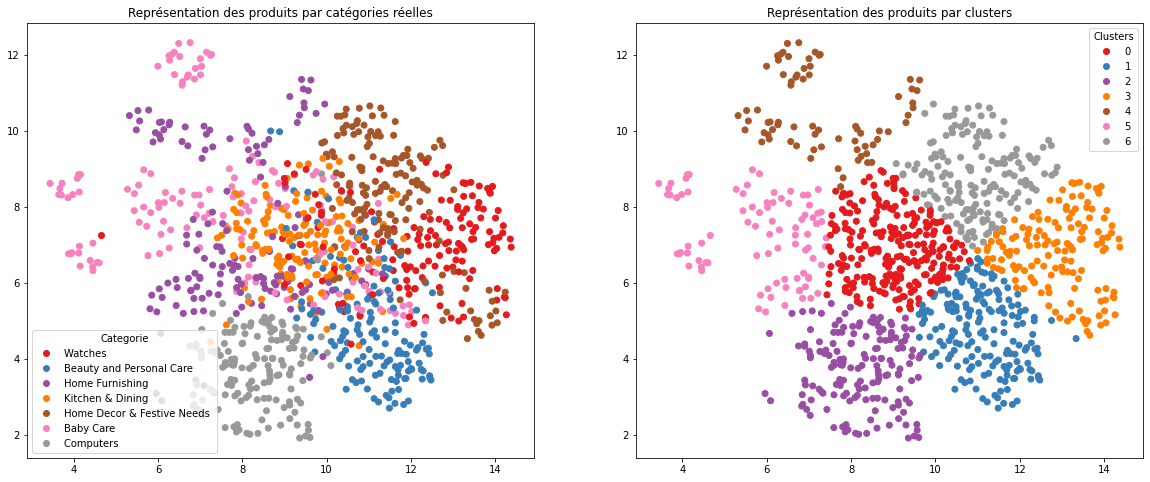

In [29]:
# UMAP + kmeans

X_reduc = reduction_fct(ctf_transform, reduc='UMAP')
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])
reduc_visu_fct(X_reduc, df['Categ_A'], labels)

ARI_results = np.append(ARI_results, [["TF-IDF", "UMAP", ARI]], axis=0)

ARI :  0.5653


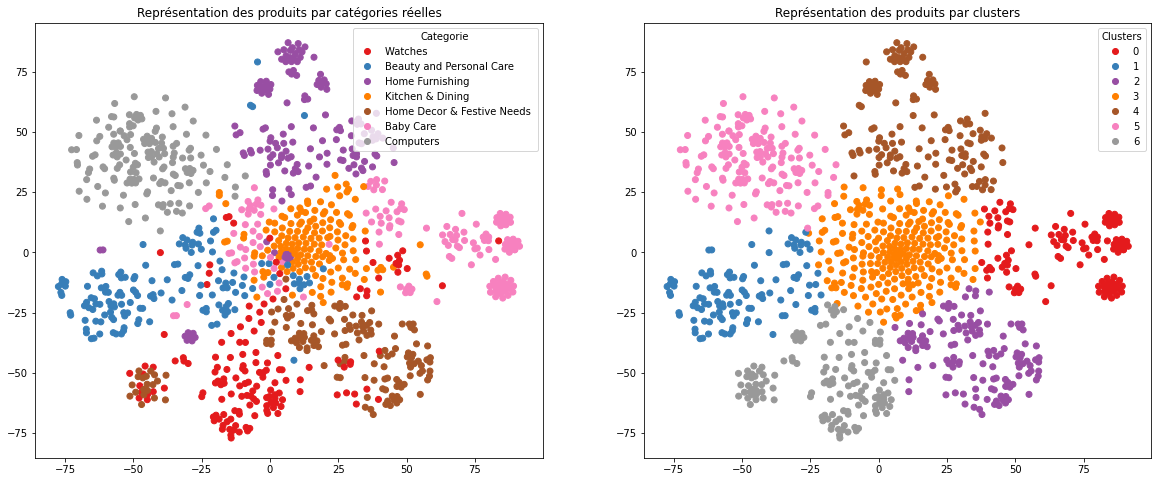

In [30]:
# TSNE + kmeans

X_reduc = reduction_fct(ctf_transform, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])
reduc_visu_fct(X_reduc, df['Categ_A'], labels)

ARI_results = np.append(ARI_results, [["TF-IDF", "TSNE", ARI]], axis=0)

## <a name="C11"> 2) Word embedding :  Word2vec</a>

In [31]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

In [32]:
df['sentence_lem'].str.len().max()

2022

In [33]:
# Préparation des phrases
sentences = df['sentence_lem'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

### a) CBOW

In [34]:
# Création et entraînement du modèle Word2Vec

# Hyper-paramètres
w2v_size = 1200
w2v_window = 5
w2v_min_count = 1
w2v_epochs = 100
maxlen = df['sentence_lem'].str.len().max()  # adapt to length of sentences

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count,
                                   window=w2v_window,
                                   vector_size=w2v_size,
                                   sg=0,  # CBOW
                                   seed=42,
                                   workers=6)

w2v_model.build_vocab(sentences)
w2v_model.train(
    sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 3161
Word2Vec trained


In [35]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                            maxlen=maxlen,
                            padding='post')

num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 3162


In [36]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i = 0
j = 0

for word, idx in word_index.items():
    i += 1
    if word in w2v_words:
        j += 1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]

word_rate = np.round(j/i, 4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (3162, 1200)


In [37]:
# Création du modèle

input = Input(shape=(len(x_sentences), maxlen), dtype='float64')
word_input = Input(shape=(maxlen,), dtype='float64')
word_embedding = Embedding(input_dim=vocab_size,
                           output_dim=w2v_size,
                           weights=[embedding_matrix],
                           input_length=maxlen)(word_input)
word_vec = GlobalAveragePooling1D()(word_embedding)
embed_model = Model([word_input], word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2022)]            0         
                                                                 
 embedding (Embedding)       (None, 2022, 1200)        3794400   
                                                                 
 global_average_pooling1d (G  (None, 1200)             0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 3,794,400
Trainable params: 3,794,400
Non-trainable params: 0
_________________________________________________________________


In [38]:
# Création des features par description du corpus
embeddings = embed_model.predict(x_sentences)
embeddings.shape

33/33 [==============================] - 3s 81ms/step


(1050, 1200)

In [39]:
# kmeans

ARI, labels = kmeans_fct(embeddings, df['Categ_A'])

ARI_results = np.append(ARI_results, [["Word2Vec(CBOW)","None", ARI]], axis=0)

ARI :  0.1649


Number of dimensions before TSVD: 1200
Number of dimensions after TSVD (99% var. explained): 43
ARI :  0.165


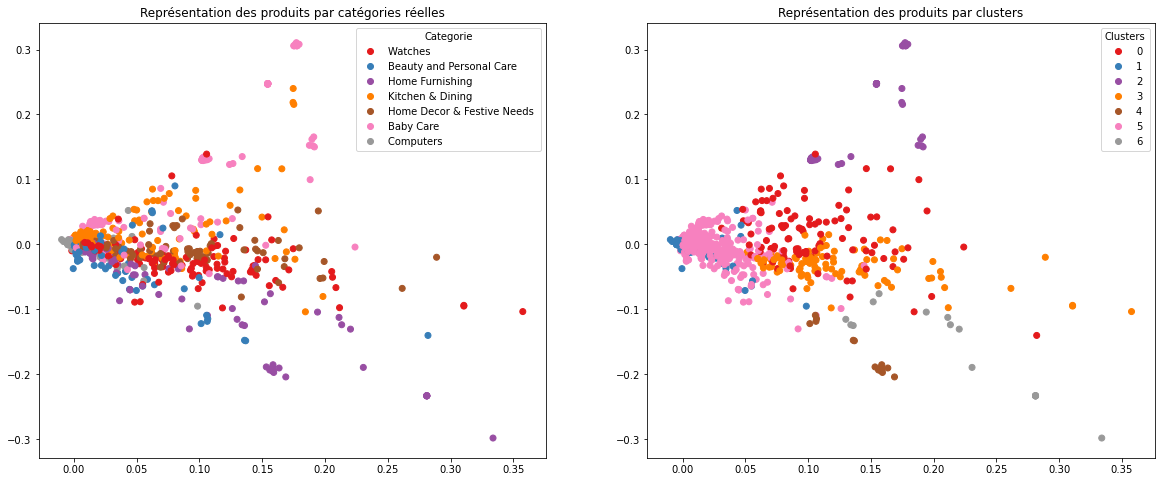

In [40]:
# SVD + kmeans

X_reduc = reduction_fct(embeddings, reduc='SVD')
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])
reduc_visu_fct(X_reduc, df['Categ_A'], labels)

ARI_results = np.append(ARI_results, [["Word2Vec(CBOW)", "SVD", ARI]], axis=0)

ARI :  0.4148


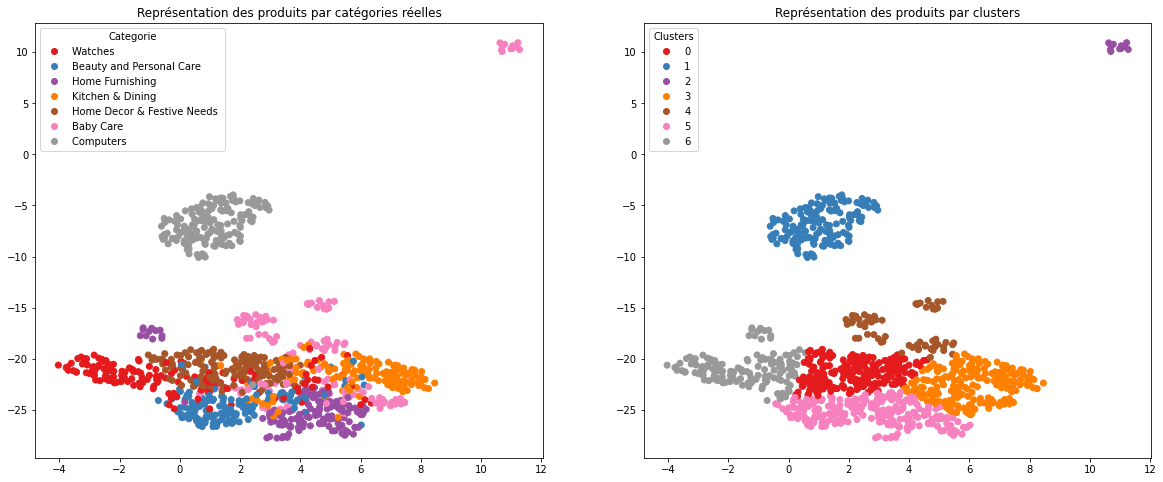

In [41]:
# UMAP + kmeans

X_reduc = reduction_fct(embeddings, reduc='UMAP')
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])
reduc_visu_fct(X_reduc, df['Categ_A'], labels, )

ARI_results = np.append(ARI_results, [["Word2Vec(CBOW)", "UMAP", ARI]], axis=0)

ARI :  0.5304


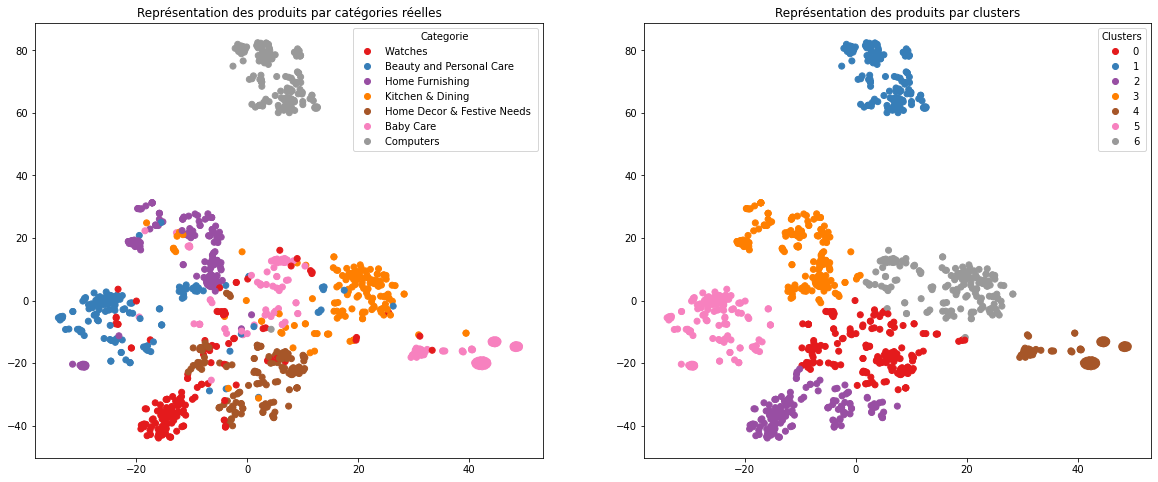

In [42]:
# TSNE + kmeans

X_reduc = reduction_fct(embeddings, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])
reduc_visu_fct(X_reduc, df['Categ_A'], labels, )

ARI_results = np.append(ARI_results, [["Word2Vec(CBOW)", "TSNE", ARI]], axis=0)

### b) Skip-Gram 

In [43]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count,
                                   window=w2v_window,
                                   vector_size=w2v_size,
                                   sg=1,  # Skip gram
                                   seed=42,
                                   workers=4)

w2v_model.build_vocab(sentences)
w2v_model.train(
    sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")


# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                            maxlen=maxlen,
                            padding='post')

num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i = 0
j = 0

for word, idx in word_index.items():
    i += 1
    if word in w2v_words:
        j += 1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]

word_rate = np.round(j/i, 4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))
# Création du modèle

input = Input(shape=(len(x_sentences), maxlen), dtype='float64')
word_input = Input(shape=(maxlen,), dtype='float64')
word_embedding = Embedding(input_dim=vocab_size,
                           output_dim=w2v_size,
                           weights=[embedding_matrix],
                           input_length=maxlen)(word_input)
word_vec = GlobalAveragePooling1D()(word_embedding)
embed_model = Model([word_input], word_vec)

embed_model.summary()
embeddings = embed_model.predict(x_sentences)
embeddings.shape

Build & train Word2Vec model ...
Vocabulary size: 3161
Word2Vec trained
Fit Tokenizer ...
Number of unique words: 3162
Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (3162, 1200)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 2022)]            0         
                                                                 
 embedding_1 (Embedding)     (None, 2022, 1200)        3794400   
                                                                 
 global_average_pooling1d_1   (None, 1200)             0         
 (GlobalAveragePooling1D)                                        
                                                                 
Total params: 3,794,400
Trainable params: 3,794,400
Non-trainable params: 0
_________________________________________________________________
33/33 [==============================] - 3

(1050, 1200)

In [44]:
ARI, labels = kmeans_fct(embeddings, df['Categ_A'])

ARI_results = np.append(ARI_results, [["Word2Vec(SG)", "None", ARI]], axis=0)

ARI :  0.0405


Number of dimensions before TSVD: 1200
Number of dimensions after TSVD (99% var. explained): 79
ARI :  0.0397


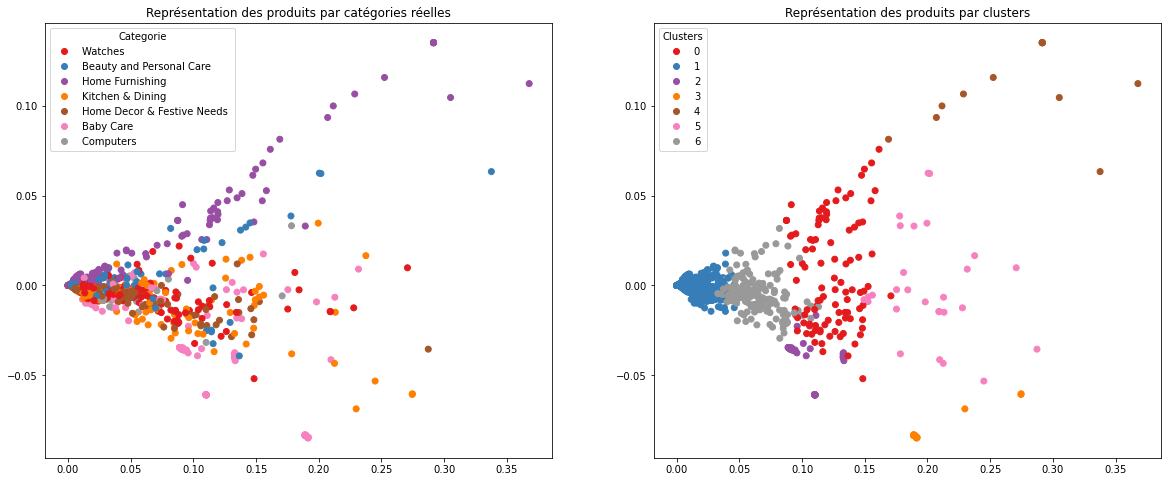

In [45]:
X_reduc = reduction_fct(embeddings, reduc='SVD')
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])
reduc_visu_fct(X_reduc, df['Categ_A'], labels)

ARI_results = np.append(ARI_results, [["Word2Vec(SG)", "SVD", ARI]], axis=0)

ARI :  0.3002


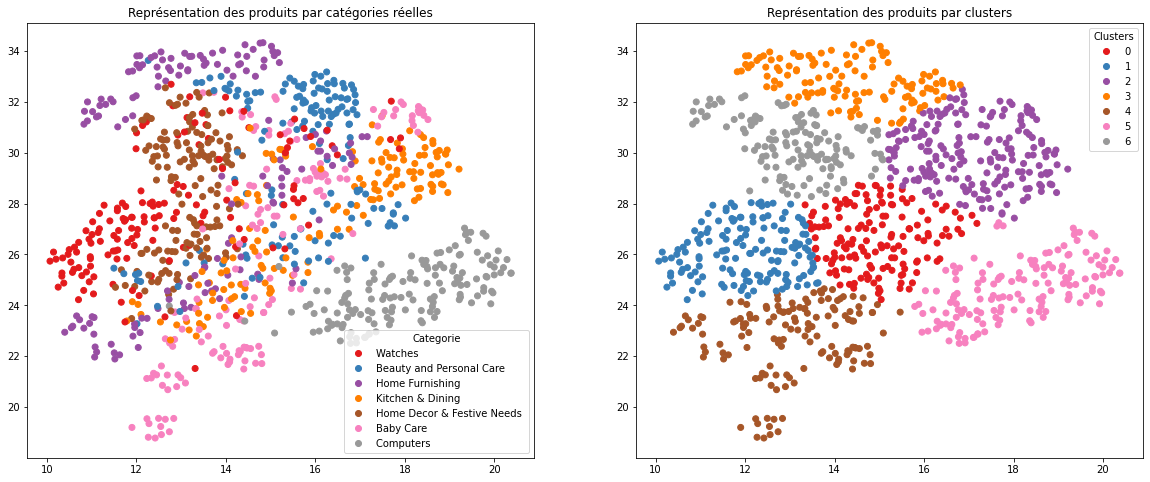

In [46]:
X_reduc = reduction_fct(embeddings, reduc='UMAP')
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])
reduc_visu_fct(X_reduc, df['Categ_A'], labels, )

ARI_results = np.append(ARI_results, [["Word2Vec(SG)", "UMAP", ARI]], axis=0)

ARI :  0.3449


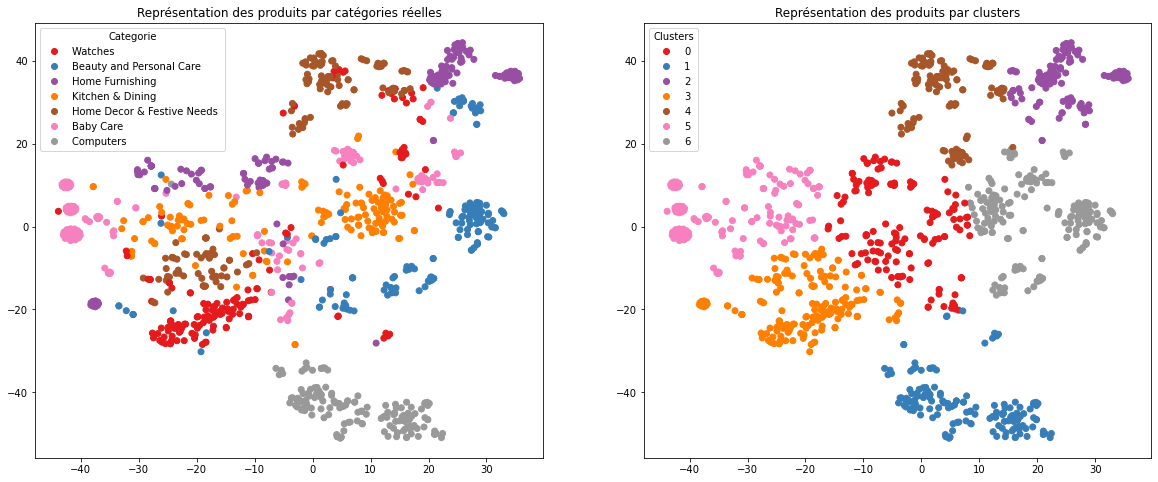

In [47]:
X_reduc = reduction_fct(embeddings, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])
reduc_visu_fct(X_reduc, df['Categ_A'], labels, )

ARI_results = np.append(ARI_results, [["Word2Vec(SG)", "TSNE", ARI]], axis=0)

## <a name="C12"> 3) Word embedding : FastText</a>

### a) CBOW

In [48]:
# Création et entraînement du modèle FastText

FT_size = 600
print("Build & train FastText model ...")
FT_model = gensim.models.FastText(min_count=w2v_min_count, window=w2v_window,
                                  vector_size=FT_size,
                                  seed=42,
                                  sg=0,
                                  workers=4)

FT_model.build_vocab(sentences)
FT_model.train(sentences, total_examples=FT_model.corpus_count,
               epochs=w2v_epochs)
model_vectors = FT_model.wv
FT_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(FT_words))
print("FastText trained")

Build & train FastText model ...
Vocabulary size: 3161
FastText trained


In [49]:
print("Create Embedding matrix ...")

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, FT_size))
i = 0
j = 0

for word, idx in word_index.items():
    i += 1
    if word in FT_words:
        j += 1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]

word_rate = np.round(j/i, 4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (3162, 600)


In [50]:
# Création du modèle

input = Input(shape=(len(x_sentences), maxlen), dtype='float64')
word_input = Input(shape=(maxlen,), dtype='float64')
word_embedding = Embedding(input_dim=vocab_size,
                           output_dim=FT_size,
                           weights=[embedding_matrix],
                           input_length=maxlen)(word_input)
word_vec = GlobalAveragePooling1D()(word_embedding)
embed_model = Model([word_input], word_vec)

embed_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 2022)]            0         
                                                                 
 embedding_2 (Embedding)     (None, 2022, 600)         1897200   
                                                                 
 global_average_pooling1d_2   (None, 600)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
Total params: 1,897,200
Trainable params: 1,897,200
Non-trainable params: 0
_________________________________________________________________


In [51]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

33/33 [==============================] - 2s 50ms/step


(1050, 600)

In [52]:
ARI, labels = kmeans_fct(embeddings, df['Categ_A'])

ARI_results = np.append(ARI_results, [["FastText(CBOW)", "None", ARI]], axis=0)

ARI :  0.1645


Number of dimensions before TSVD: 600
Number of dimensions after TSVD (99% var. explained): 42
ARI :  0.1638


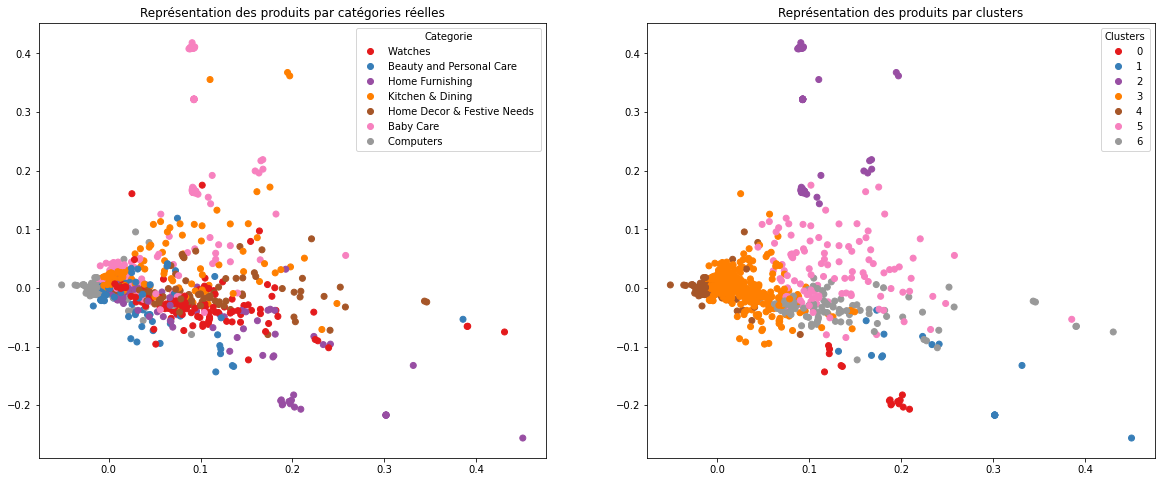

In [53]:
X_reduc = reduction_fct(embeddings, reduc='SVD')
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])
reduc_visu_fct(X_reduc, df['Categ_A'], labels, )

ARI_results = np.append(ARI_results, [["FastText(CBOW)", "SVD", ARI]], axis=0)

ARI :  0.5021


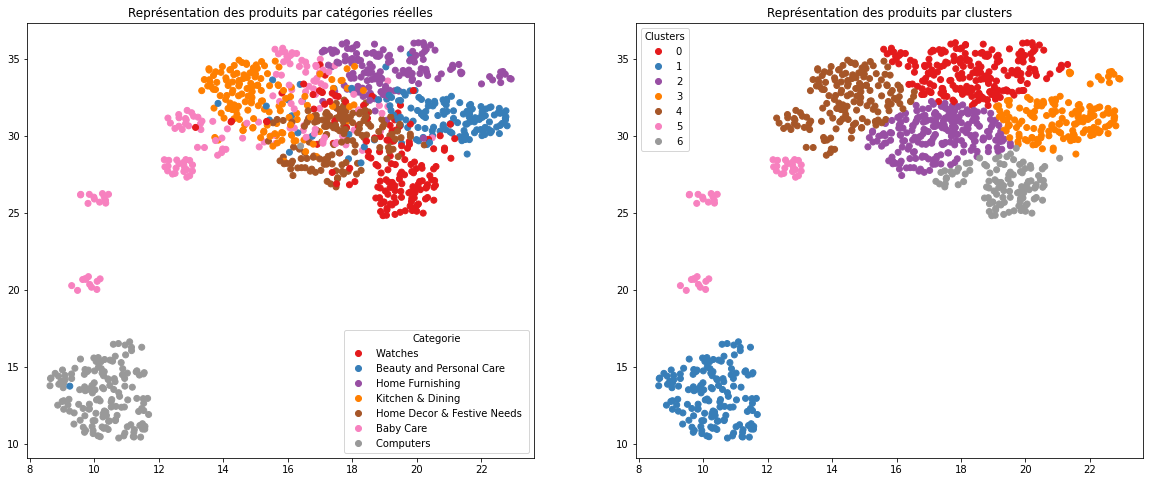

In [54]:
X_reduc = reduction_fct(embeddings, reduc='UMAP')
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])
reduc_visu_fct(X_reduc, df['Categ_A'], labels, )

ARI_results = np.append(ARI_results, [["FastText(CBOW)", "UMAP", ARI]], axis=0)

ARI :  0.5235


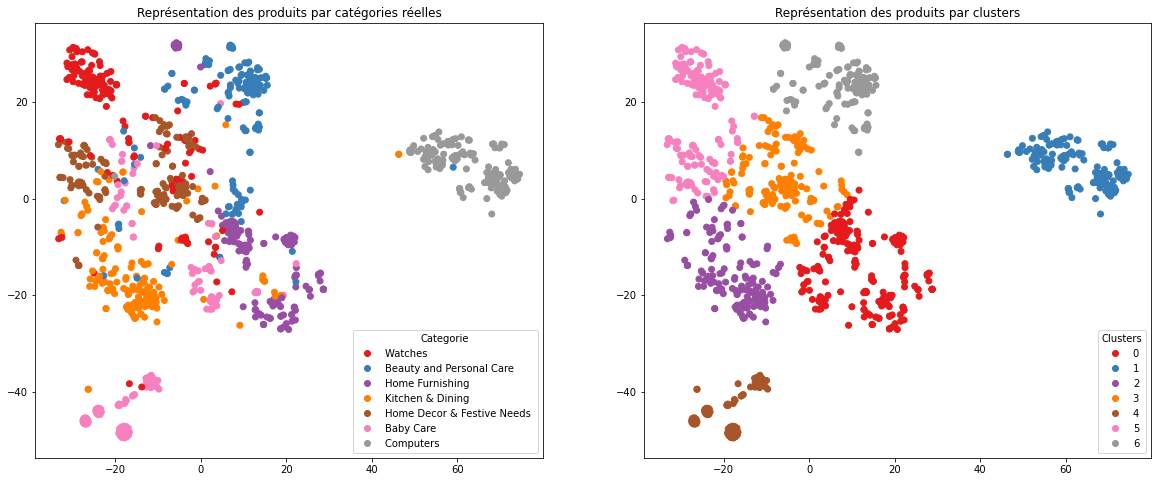

In [55]:
X_reduc = reduction_fct(embeddings, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])
reduc_visu_fct(X_reduc, df['Categ_A'], labels, )

ARI_results = np.append(ARI_results, [["FastText(CBOW)", "TSNE", ARI]], axis=0)

### b) Skip-Gram

In [56]:
# Création et entraînement du modèle FastText
FT_size = 600

print("Build & train FastText model ...")
FT_model = gensim.models.FastText(min_count=w2v_min_count, window=w2v_window,
                                  vector_size=FT_size,
                                  seed=42,
                                  sg=1,
                                  workers=4)

FT_model.build_vocab(sentences)
FT_model.train(sentences, total_examples=FT_model.corpus_count,
               epochs=w2v_epochs)
model_vectors = FT_model.wv
FT_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(FT_words))
print("FastText trained")


print("Create Embedding matrix ...")
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, FT_size))
i = 0
j = 0

for word, idx in word_index.items():
    i += 1
    if word in FT_words:
        j += 1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]

word_rate = np.round(j/i, 4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))
# Création du modèle

input = Input(shape=(len(x_sentences), maxlen), dtype='float64')
word_input = Input(shape=(maxlen,), dtype='float64')
word_embedding = Embedding(input_dim=vocab_size,
                           output_dim=FT_size,
                           weights=[embedding_matrix],
                           input_length=maxlen)(word_input)
word_vec = GlobalAveragePooling1D()(word_embedding)
embed_model = Model([word_input], word_vec)

embed_model.summary()
embeddings = embed_model.predict(x_sentences)
embeddings.shape

Build & train FastText model ...
Vocabulary size: 3161
FastText trained
Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (3162, 600)
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 2022)]            0         
                                                                 
 embedding_3 (Embedding)     (None, 2022, 600)         1897200   
                                                                 
 global_average_pooling1d_3   (None, 600)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
Total params: 1,897,200
Trainable params: 1,897,200
Non-trainable params: 0
_________________________________________________________________
33/33 [==============================] - 2s 44ms/step


(1050, 600)

In [57]:
ARI, labels = kmeans_fct(embeddings, df['Categ_A'])

ARI_results = np.append(ARI_results, [["FastText(SG)", "None", ARI]], axis=0)

ARI :  0.0361


Number of dimensions before TSVD: 600
Number of dimensions after TSVD (99% var. explained): 74
ARI :  0.0338


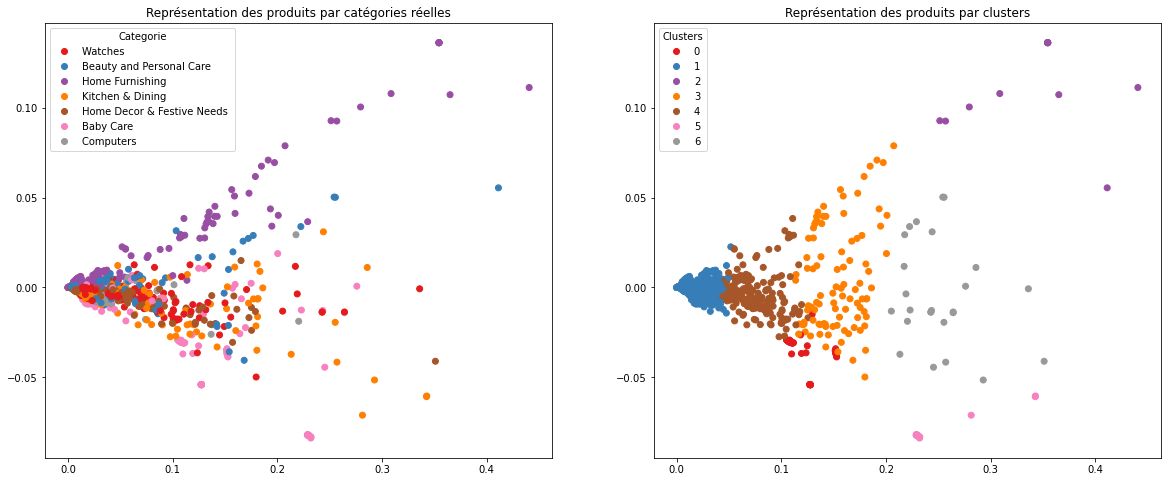

In [58]:
X_reduc = reduction_fct(embeddings, reduc='SVD')
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])
reduc_visu_fct(X_reduc, df['Categ_A'], labels, )

ARI_results = np.append(ARI_results, [["FastText(SG)", "SVD", ARI]], axis=0)

ARI :  0.2517


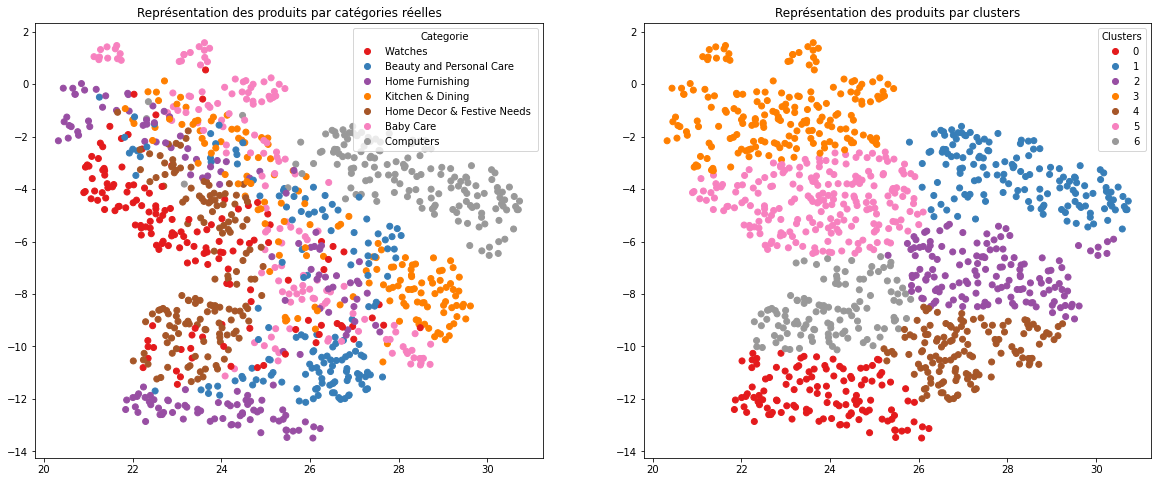

In [59]:
X_reduc = reduction_fct(embeddings, reduc='UMAP')
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])
reduc_visu_fct(X_reduc, df['Categ_A'], labels, )

ARI_results = np.append(ARI_results, [["FastText(SG)", "UMAP", ARI]], axis=0)

ARI :  0.3086


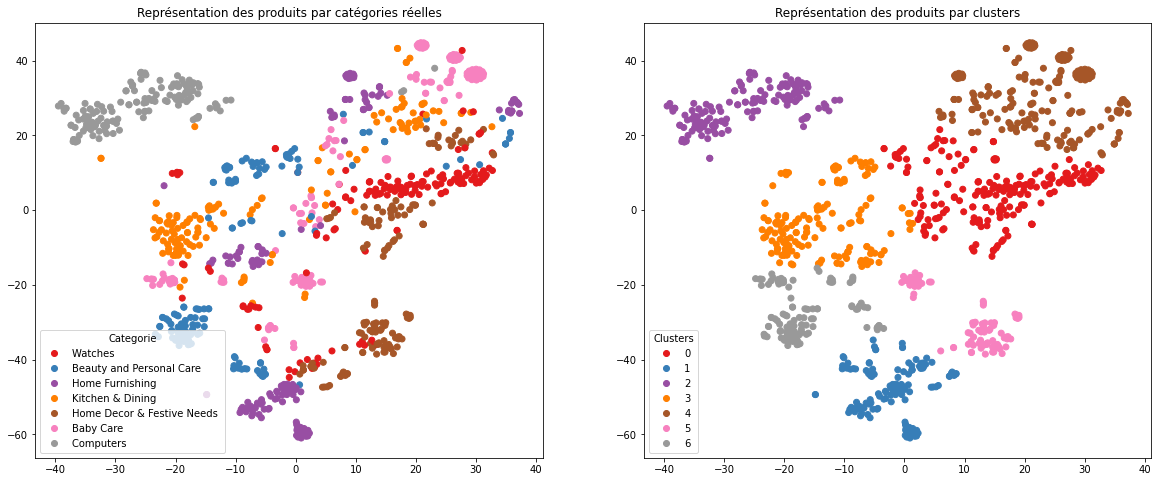

In [60]:
X_reduc = reduction_fct(embeddings, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])
reduc_visu_fct(X_reduc, df['Categ_A'], labels, )

ARI_results = np.append(ARI_results, [["FastText(SG)", "TSNE", ARI]], axis=0)

## <a name="C13"> 4) Word embedding : BERT</a>

In [61]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import os
from transformers import TFAutoModel, TFBertModel, AutoTokenizer
#from transformers import *

In [62]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = df['sentence_lem'].to_list()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [63]:
model.summary()

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
Total params: 109,482,240
Trainable params: 109,482,240
Non-trainable params: 0
_________________________________________________________________


### a) BERT with HuggingFace

In [64]:
# Création des features

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences,
                                                         max_length, batch_size, mode='HF')

100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [02:32<00:00,  1.45s/it]

temps traitement :  153.0


In [65]:
ARI, labels = kmeans_fct(features_bert, df['Categ_A'])

ARI_results = np.append(
    ARI_results, [["BERT(HuggingFace)", "None", ARI]], axis=0)

ARI :  0.2429


Number of dimensions before TSVD: 768
Number of dimensions after TSVD (99% var. explained): 336
ARI :  0.2429


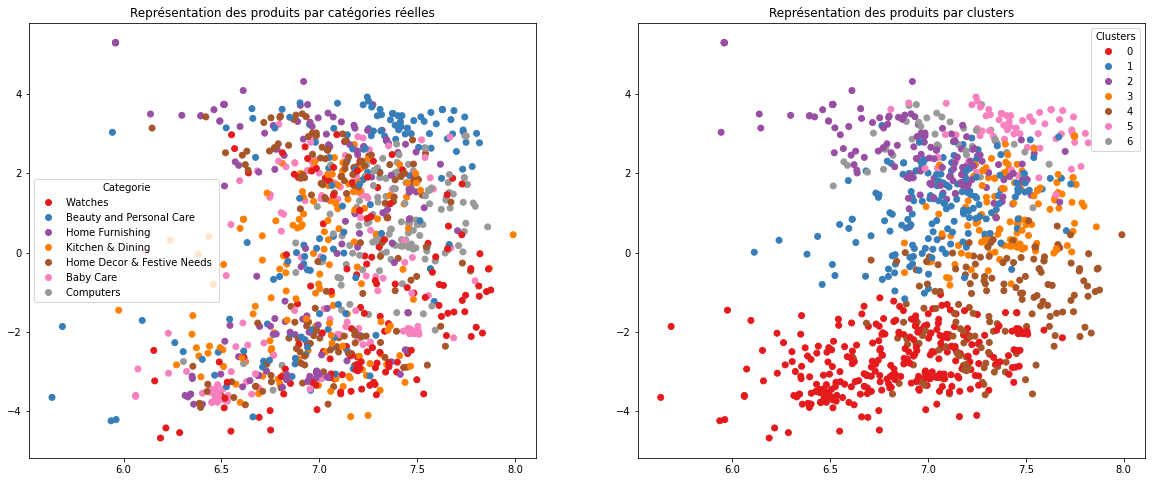

In [66]:
X_reduc_SVD = reduction_fct(features_bert, reduc='SVD')
ARI, labels = kmeans_fct(X_reduc_SVD, df['Categ_A'])
reduc_visu_fct(X_reduc_SVD, df['Categ_A'], labels)

ARI_results = np.append(
    ARI_results, [["BERT(HuggingFace)", "SVD", ARI]], axis=0)

ARI :  0.2674


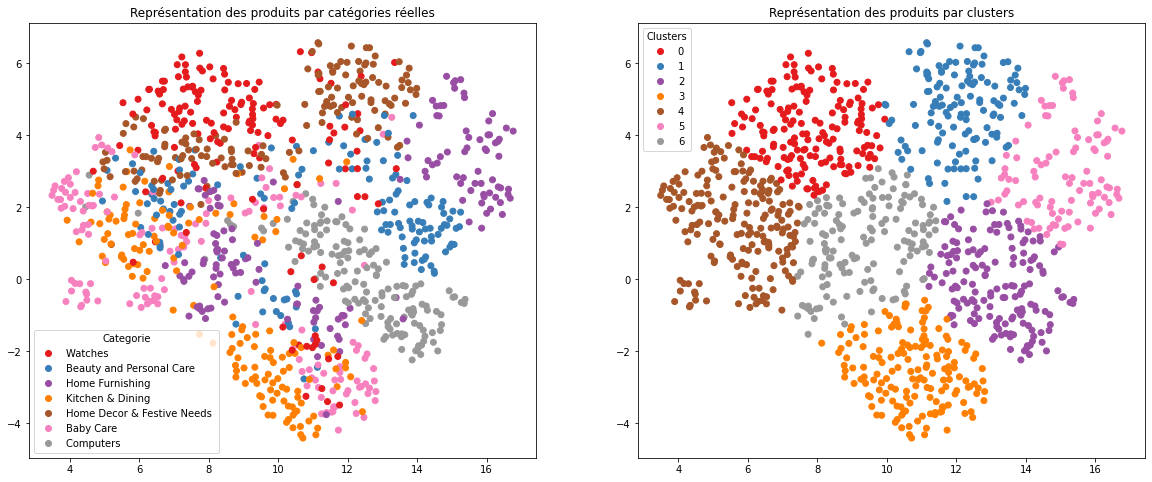

In [67]:
X_reduc = reduction_fct(features_bert, reduc='UMAP')
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])
reduc_visu_fct(X_reduc, df['Categ_A'], labels, )

ARI_results = np.append(
    ARI_results, [["BERT(HuggingFace)", "UMAP", ARI]], axis=0)

ARI :  0.2972


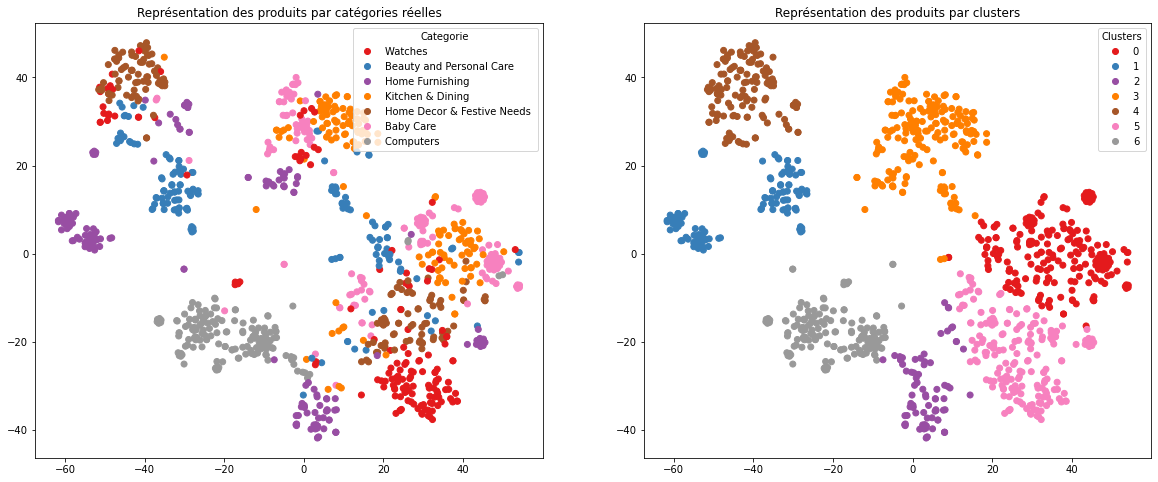

In [68]:
X_reduc = reduction_fct(features_bert, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])
reduc_visu_fct(X_reduc, df['Categ_A'], labels, )

ARI_results = np.append(
    ARI_results, [["BERT(HuggingFace)", "TSNE", ARI]], axis=0)

### b) BERT with Tensorflow

In [69]:
import tensorflow_hub as hub
#import tensorflow_text

# Guide sur le Tensorflow hub : https://www.tensorflow.org/text/tutorials/classify_text_with_bert
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_layer = hub.KerasLayer(model_url, trainable=True)

In [70]:
bert_layer

In [71]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = bert_layer

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences,
                                                         max_length, batch_size, mode='TFhub')

100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [01:33<00:00,  1.13it/s]

temps traitement :  93.0


In [72]:
ARI, labels = kmeans_fct(features_bert, df['Categ_A'])

#ARI_results = np.append(ARI_results, [["BERT(TensorFlow)","None", ARI]], axis=0)

ARI :  0.241


Number of dimensions before TSVD: 768
Number of dimensions after TSVD (99% var. explained): 337
ARI :  0.2438


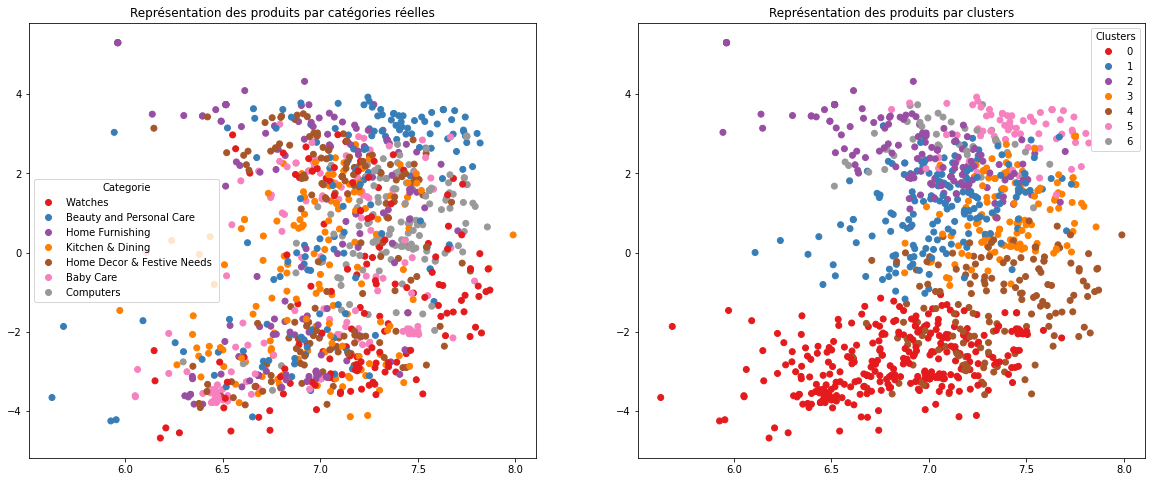

In [73]:
X_reduc = reduction_fct(features_bert, reduc='SVD')
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])
reduc_visu_fct(X_reduc, df['Categ_A'], labels, )

#ARI_results = np.append(ARI_results, [["BERT(TensorFlow)","SVD", ARI]], axis=0)

ARI :  0.2548


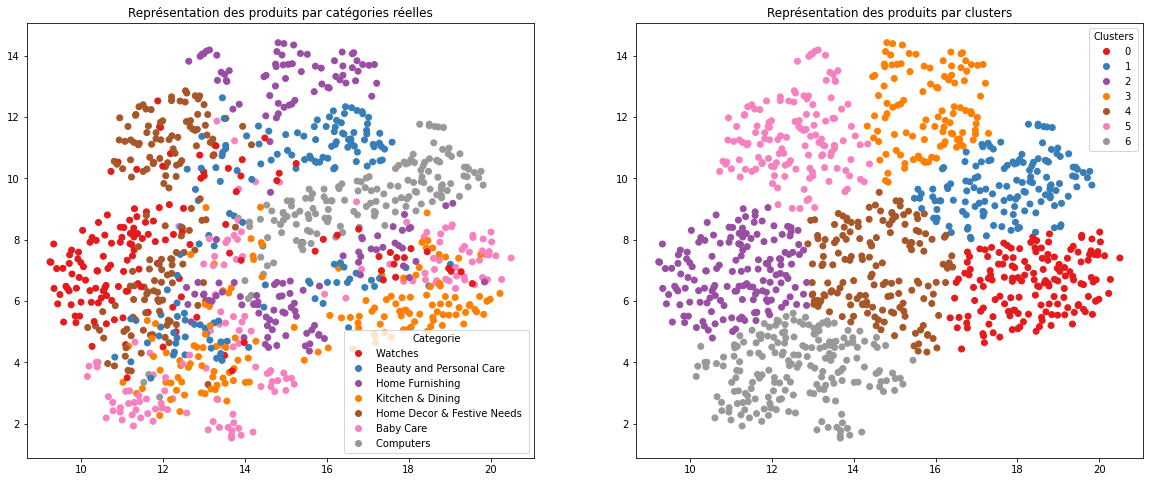

In [74]:
X_reduc = reduction_fct(features_bert, reduc='UMAP')
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])
reduc_visu_fct(X_reduc, df['Categ_A'], labels, )

#ARI_results = np.append(ARI_results, [["BERT(TensorFlow)","UMAP", ARI]], axis=0)

ARI :  0.3069


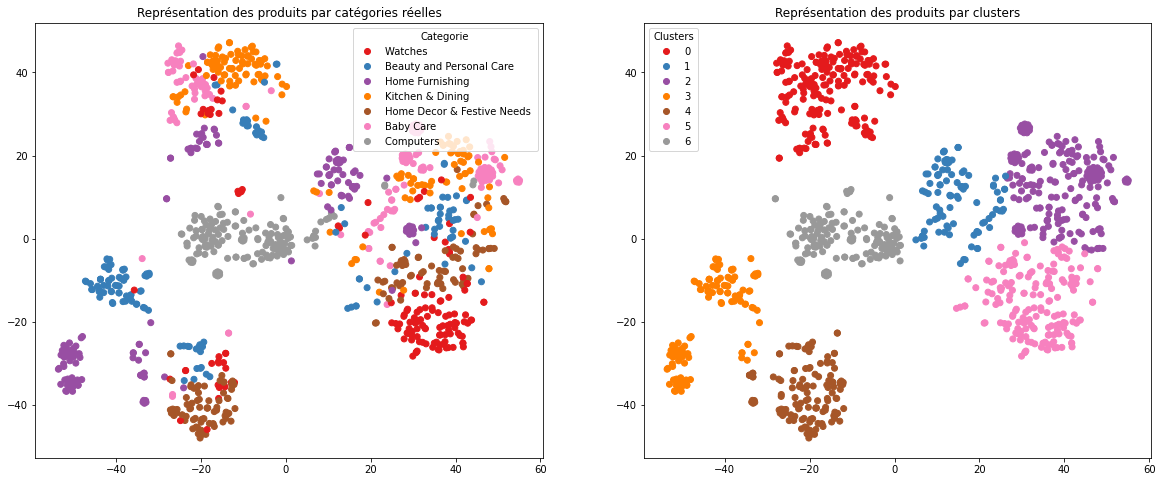

In [75]:
X_reduc = reduction_fct(features_bert, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])
reduc_visu_fct(X_reduc, df['Categ_A'], labels, )

#ARI_results = np.append(ARI_results, [["BERT(TensorFlow)","TSNE", ARI]], axis=0)

## <a name="C14"> 5) Sentence embedding : USE - Universal Sentence Encoder (DAN)</a>

In [76]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [77]:
sentences = df['sentence_lem'].to_list()

In [78]:
features_USE = feature_USE_fct(sentences, batch_size)

temps traitement :  3.0


In [79]:
ARI, labels = kmeans_fct(features_USE, df['Categ_A'])

ARI_results = np.append(ARI_results, [["USE", "None", ARI]], axis=0)

ARI :  0.439


Number of dimensions before TSVD: 512
Number of dimensions after TSVD (99% var. explained): 338
ARI :  0.4565


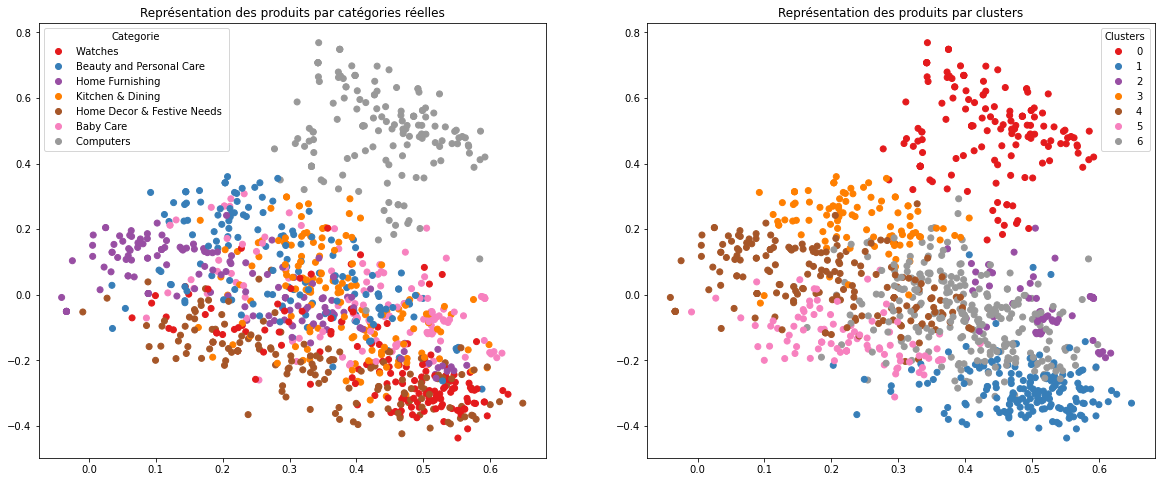

In [80]:
X_reduc = reduction_fct(features_USE, reduc='SVD')
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])
reduc_visu_fct(X_reduc, df['Categ_A'], labels, )

ARI_results = np.append(ARI_results, [["USE", "SVD", ARI]], axis=0)

ARI :  0.4226


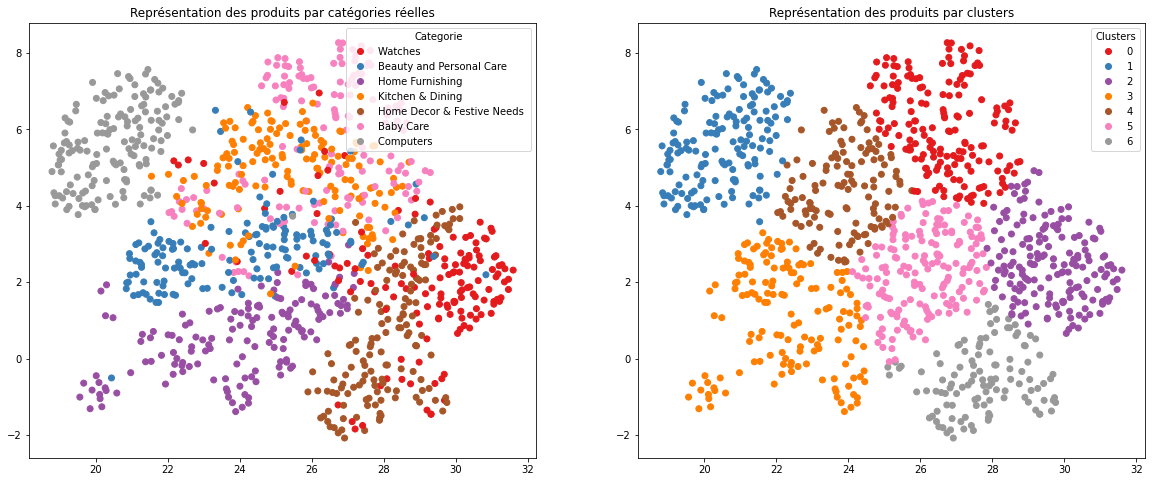

In [81]:
X_reduc = reduction_fct(features_USE, reduc='UMAP')
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])
reduc_visu_fct(X_reduc, df['Categ_A'], labels, )

ARI_results = np.append(ARI_results, [["USE", "UMAP", ARI]], axis=0)

ARI :  0.4453


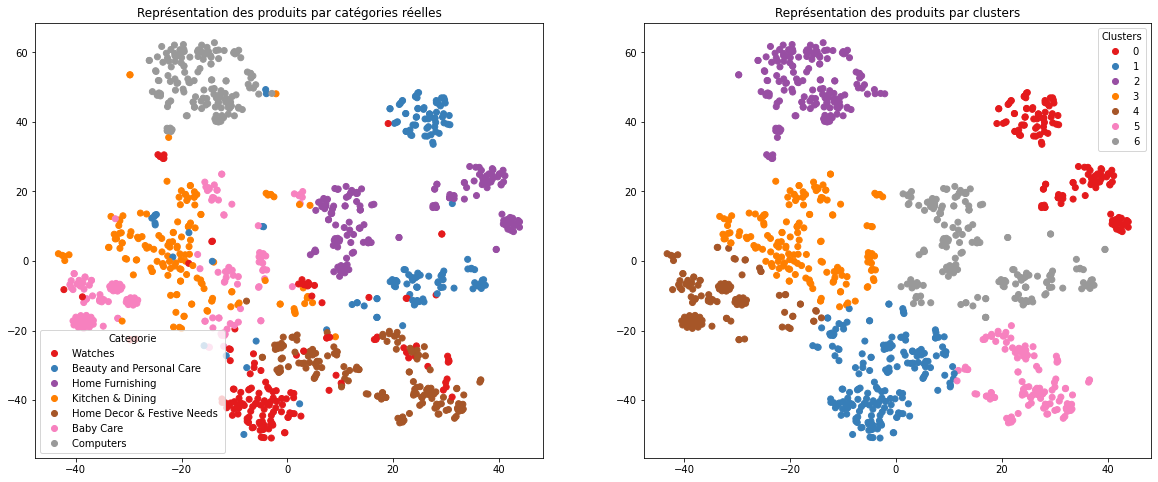

In [82]:
X_reduc = reduction_fct(features_USE, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])
reduc_visu_fct(X_reduc, df['Categ_A'], labels, )

ARI_results = np.append(ARI_results, [["USE", "TSNE", ARI]], axis=0)

## <a name="C15"> 6) Sentence embedding : Sentence-BERT</a>

In [83]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-mpnet-base-v2')

sentences = df['sentence_lem'].to_list()

embeddings = model.encode(sentences)

In [84]:
ARI, labels = kmeans_fct(embeddings, df['Categ_A'])

ARI_results = np.append(ARI_results, [["SBERT", "None", ARI]], axis=0)

ARI :  0.5051


Number of dimensions before TSVD: 768
Number of dimensions after TSVD (99% var. explained): 345
ARI :  0.5407


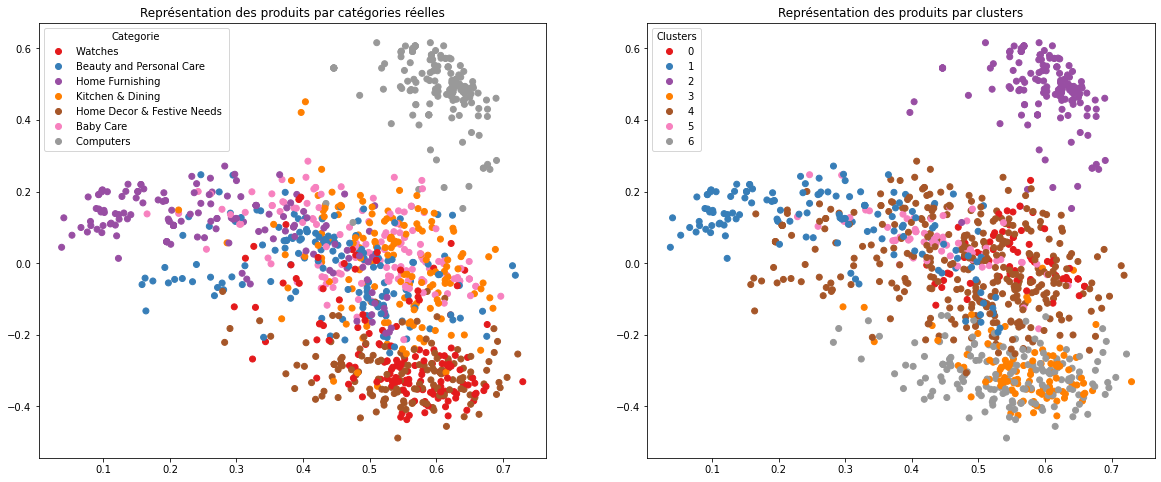

In [85]:
X_reduc = reduction_fct(embeddings, reduc='SVD')
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])
reduc_visu_fct(X_reduc, df['Categ_A'], labels, )

ARI_results = np.append(ARI_results, [["SBERT", "SVD", ARI]], axis=0)

ARI :  0.505


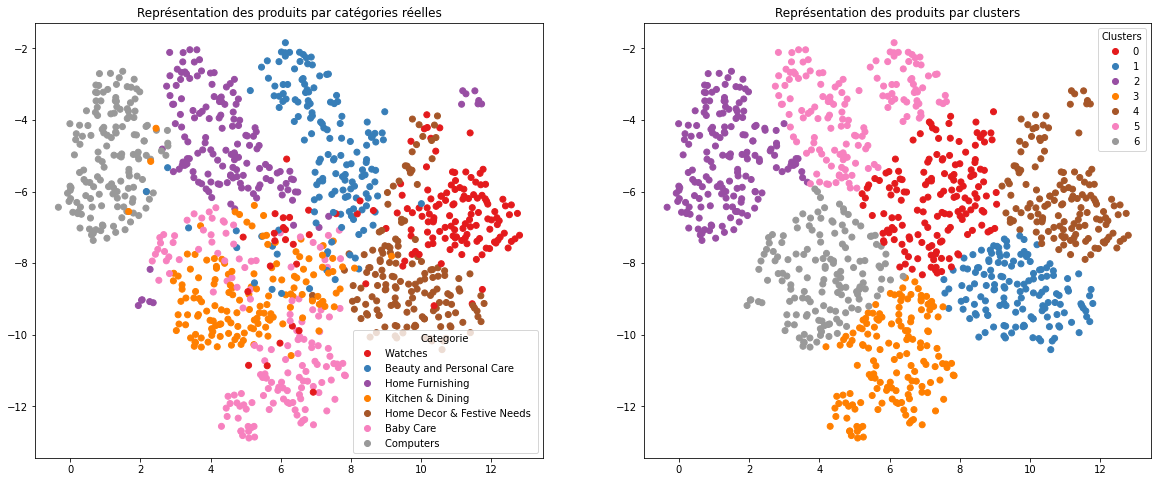

In [86]:
X_reduc = reduction_fct(embeddings, reduc='UMAP')
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])
reduc_visu_fct(X_reduc, df['Categ_A'], labels, )

ARI_results = np.append(ARI_results, [["SBERT", "UMAP", ARI]], axis=0)

ARI :  0.6875


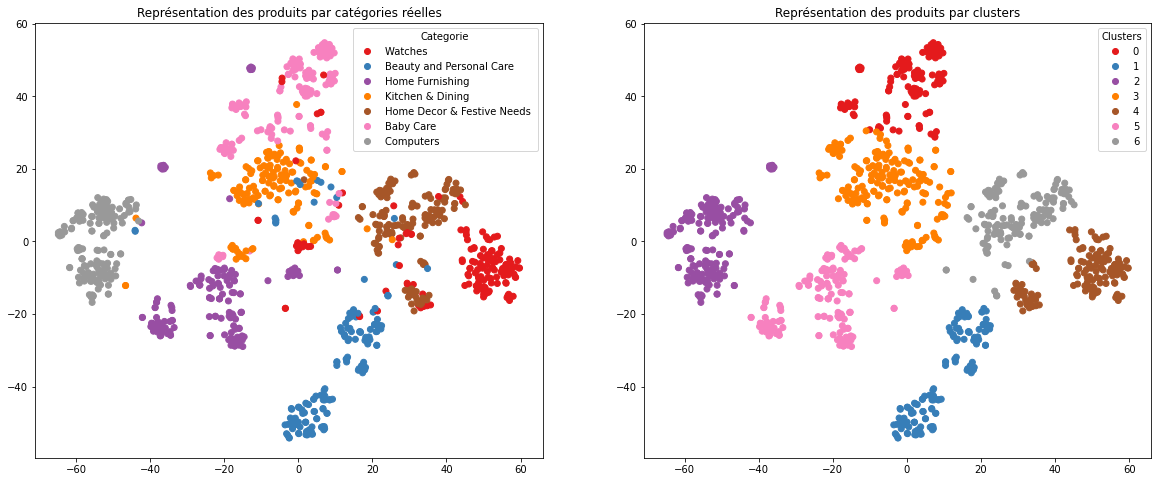

In [87]:
X_reduc = reduction_fct(embeddings, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])
reduc_visu_fct(X_reduc, df['Categ_A'], labels, )

ARI_results = np.append(ARI_results, [["SBERT", "TSNE", ARI]], axis=0)

# <a name="C16"> IV) Analyse du meilleur modèle</a>

In [88]:
# Création d'un DF
ARI_results_df = pd.DataFrame(
    ARI_results, columns=["model", "reduction", "ARI"])
ARI_results_df['ARI'] = ARI_results_df['ARI'].astype(float)

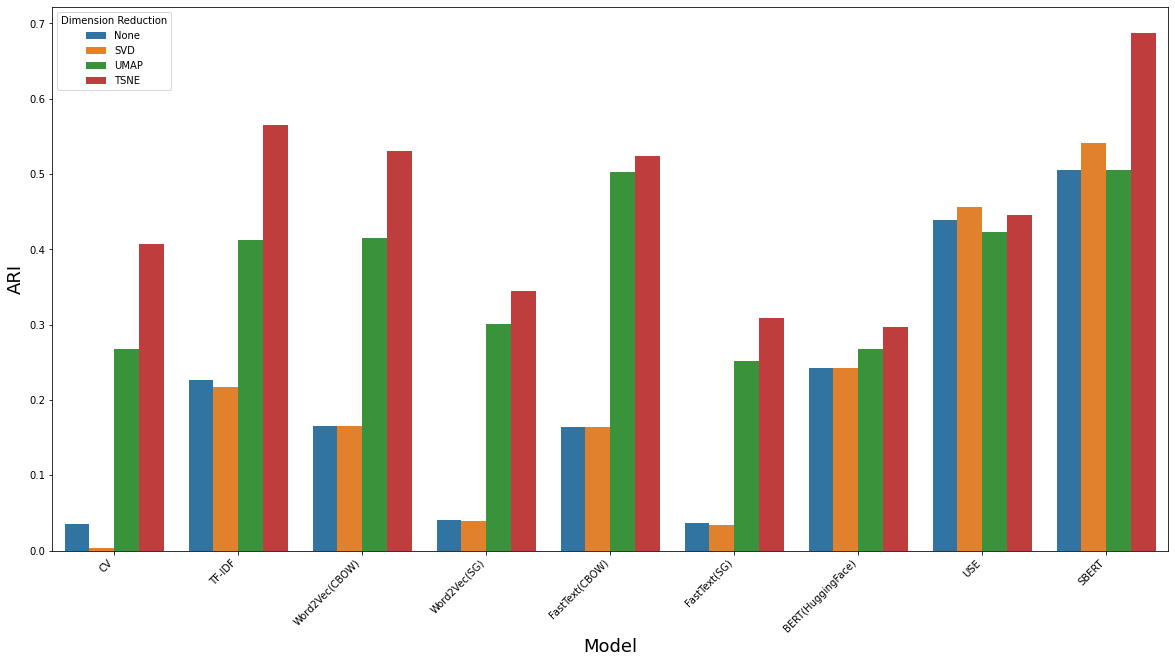

In [89]:
# Visualisation du meilleur modèle

plt.figure(figsize=(20, 10))

sns.barplot(data=ARI_results_df, x="model", y="ARI", hue="reduction")
plt.xticks(rotation=45, ha='right')
plt.legend(title='Dimension Reduction')
plt.xlabel('Model', fontsize=18)
plt.ylabel('ARI', fontsize=18)

plt.show()

In [90]:
# Les features de SBERT sont deja enregistrées dans embeddings
X_reduc = reduction_fct(embeddings, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])

ARI :  0.6875


In [91]:
# Encodage des catégories
LE = LabelEncoder()
y_categ = LE.fit_transform(df['Categ_A'])

In [92]:
# Matrice de confusion

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_categ, labels)
print(cm)

[[  6   3   0  15 112   2  12]
 [  0 128   2  13   1   0   6]
 [  5   0   8   1   0 134   2]
 [  1   0   3 130   0  14   2]
 [  0   0   0   1  24   0 125]
 [111   0   0  32   0   7   0]
 [  0   0 150   0   0   0   0]]


In [93]:
# réarrangement des clusters pour plus de visibilité (par l'algorithme Hungarian)

from scipy.optimize import linear_sum_assignment as linear_assignment


def _make_cost_m(cm):
    s = np.max(cm)
    return (- cm + s)


indexes = linear_assignment(_make_cost_m(cm))
indexes = np.array(list(zip(*indexes)))
js = [e[1] for e in sorted(indexes, key=lambda x: x[0])]
cm2 = cm[:, js]

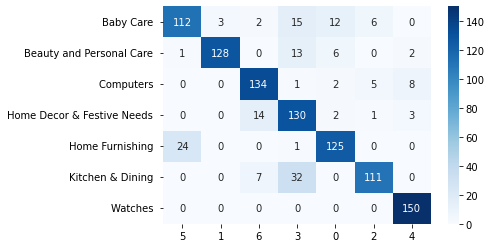

In [94]:
# DF pour renommer et graphe
df_cm = pd.DataFrame(cm2, index=[label for label in list(np.unique(df["Categ_A"]))],
                     columns=[i for i in list(np.argmax(cm, axis=0))])

ax = sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")